# Long Short-Term Memory

Sepp Hochreiter, Jürgen Schmidhuber

https://www.bioinf.jku.at/publications/older/2604.pdf

In [1]:
import os
import re
from typing import Dict
from typing import List
from typing import Tuple

import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

## 1 Why LSTM?
**The problem with vanilla RNNs** is that the gradients via back-propagation tend to "vanish" or "explode" with increasing sequence length. LSTM is designed to help with this problem to certain extent.

## 2 Model Architecture

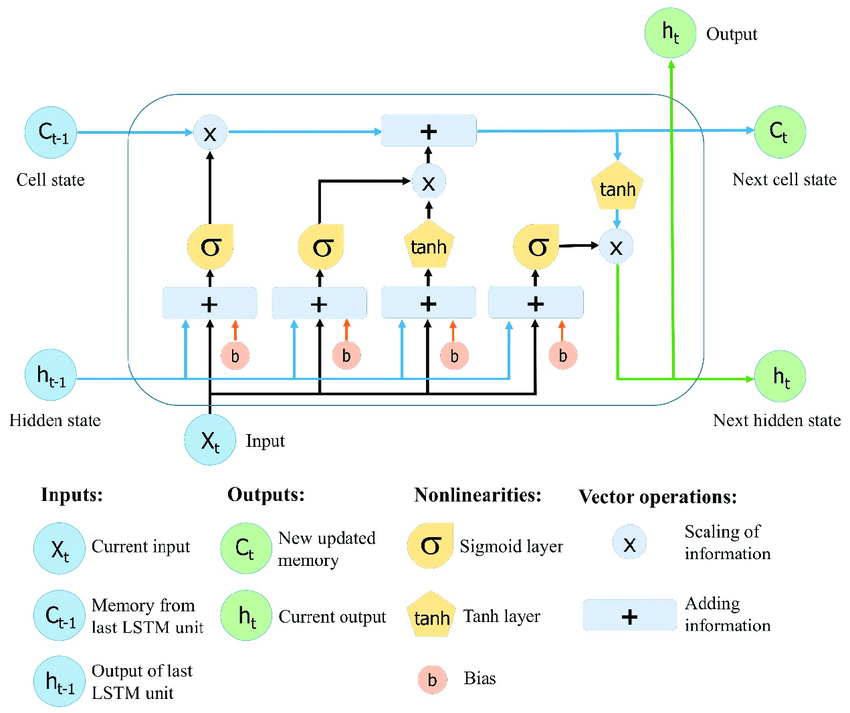

In [10]:
Image(filename='lstm.png')

A LSTM cell takes care of three pieces of information:
 - hidden state $h_t$ carries the short-term information.
 - memory cell $c_t$ carries the long-term information.
 - input $x_t$
 
LSTM process the information flow with three **Gates** in following steps:

1) **forget gate**: decides how much information should be droped from memory:

$$f_t=\sigma(W_fh_{t-1}+U_fx_t+b_f)$$

2) **input gate**: decies how much information should be added to the memory:

$$i_t=\sigma(W_ih_{t-1}+U_ix_t+b_i)$$

3) A new candidate memory value is calulcated as:

$$\tilde{c}_t=\tanh(W_ch_{t-1}+U_cx_t+b_c)$$

4) The memory cell state is updated by dropping current and adding new information:

$$c_t=f_tc_{t-1}+i_t\tilde{c}_t$$

5) **output gate**: decides how much information should be outputed to the new hidden:

$$o_t=\sigma(W_oh_{t-1}+U_ox_t+b_o)$$

6) The hidden state is updated as:

$$h_t=o_t\tanh(c_t)$$

7) The prediction is then made according to the task (here we assume a classification):

$$\hat{y}_t=softmax(W_yh_t+b_y)$$

Keras provides both single [tf.keras.layers.LSTMCell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell) and [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer. Following is a detailed look into how it actually works

In [11]:
class LSTMCell(tf.keras.layers.Layer):
    """A single step LSTM cell.

    Args:
        hidden_dim: Dimensionality of the hidden state.
    Inputs:
        inputs: List of inputs
            - x: input of current step, of shape (batch_size, x_dim)
            - hidden_state: hidden state of previous step, 
                of shape (batch_size, hidden_dim)
            - memory: memory cell of previous step,
                of shape (batch_size, hidden_dim)
    Returns:
        hidden_state: Updated hidden state, of shape (batch_size, hidden_dim)
        memory: Update memory cell, of shape (batch_size, hidden_dim)
    """
    def __init__(self, hidden_dim: int, name: str="lstm_cell"):
        super(LSTMCell, self).__init__(name=name)
        self.hidden_dim = hidden_dim
    
    def build(self, input_shape):
        weights_dim = input_shape[0][1] + input_shape[1][1]
        
        # Weights variables of shape (x_dim+hidden_dim, hidden_dim)
        self.w_f = self.add_weight("forget_weights", 
                                   shape=(weights_dim, self.hidden_dim), 
                                   initializer="glorot_uniform", 
                                   trainable=True)
        self.w_i = self.add_weight("input_weights", 
                                   shape=(weights_dim, self.hidden_dim), 
                                   initializer="glorot_uniform", 
                                   trainable=True)
        self.w_o = self.add_weight("output_weights", 
                                   shape=(weights_dim, self.hidden_dim), 
                                   initializer="glorot_uniform", 
                                   trainable=True)
        self.w_c = self.add_weight("candidate_weights", 
                                   shape=(weights_dim, self.hidden_dim), 
                                   initializer="glorot_uniform", 
                                   trainable=True)
        
        # Bias variables of shape (hidden_dim, )
        self.b_f = self.add_weight("forget_bias", 
                                   shape=(self.hidden_dim, ), 
                                   initializer="zero", 
                                   trainable=True)
        self.b_i = self.add_weight("input_bias", 
                                   shape=(self.hidden_dim, ), 
                                   initializer="zero", 
                                   trainable=True)
        self.b_o = self.add_weight("output_bias", 
                                   shape=(self.hidden_dim, ), 
                                   initializer="zero", 
                                   trainable=True)
        self.b_c = self.add_weight("candidate_bias", 
                                   shape=(self.hidden_dim, ), 
                                   initializer="zero", 
                                   trainable=True)
    
    def call(self, inputs: List[tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
        # Inputs:
        #  - x: input of current step, of shape (batch_size, x_dim)
        #  - hidden_state: hidden state of previous step, of shape (batch_size, hidden_dim)
        #  - memory: memory cell of previous step, of shape (batch_size, hidden_dim)
        x, hidden_state, memory = inputs

        x = tf.concat([x, hidden_state], axis=1)
        
        # Forget gate, of shape (batch_size, hidden_dim)
        f_gate = tf.keras.activations.sigmoid(tf.matmul(x, self.w_f)+self.b_f)
        # Input gate, of shape (batch_size, hidden_dim)
        i_gate = tf.keras.activations.sigmoid(tf.matmul(x, self.w_i)+self.b_i)
        # New memory candidate, of shape (batch_size, hidden_dim)
        candidate = tf.keras.activations.tanh(tf.matmul(x, self.w_c)+self.b_c)
        # Updated memory, of shape (batch_size, hidden_dim)
        memory = f_gate * memory + i_gate * candidate
        # Output gate, of shape (batch_size, hidden_dim)
        o_gate = tf.keras.activations.sigmoid(tf.matmul(x, self.w_o)+self.b_o)
        # Updated hidden state, of shape (batch_size, hidden_dim)
        hidden_state = o_gate * tf.keras.activations.tanh(memory)
        
        return hidden_state, memory

In [12]:
# Example
EMB_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 32

embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size+1, # +1 for padding
                                            output_dim=EMB_DIM)
embeddings = embedding_layer(input_sequences)
x = embeddings[:, 0, :]
hidden_state = tf.zeros([BATCH_SIZE, HIDDEN_DIM])
memory = tf.zeros([BATCH_SIZE, HIDDEN_DIM])

lstm_cell = LSTMCell(HIDDEN_DIM)
hidden, memory = lstm_cell([x, hidden_state, memory])
print(f"hidden state: - {hidden.shape}")
print(f"memory cell: - {memory.shape}")

hidden state: - (8, 256)
memory cell: - (8, 256)
